[IEEE ICMLA 2019](https://www.icmla-conference.org/icmla19/)

[The Data Science landscape: foundations, tools, and practical applications](https://www.icmla-conference.org/icmla19/links/tutorialAM.htm)

# Machine learning and data science

In this section we will use the [Kaggle's version of the Pima Indians diabetes database](https://www.kaggle.com/uciml/pima-indians-diabetes-database):

> This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The dataset has several predictors variables (features, attributes) and one target variable (label):

> The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Our goal is to use the features (attributes) in the dataset to predict the label (wheter or not a patient has diabetes).

We will use machine learning for that:

1. Load and inspect the dataset
1. Split into features and labels
1. Split into train and test datasets
1. Create and evaluate models

## 1. Loading and inspecting the dataset

In [2]:
import pandas as pd

# Note that we don't need to unzip to read the file
df = pd.read_csv('data/pima-indians-diabetes-database.zip')

In [3]:
df.shape

(768, 9)

In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


By inspecting the dataset, we found out that:

- It has 768 rows and 9 columns (`shape`).
- The values of the columns seem to be in the range of what they are supposed to represent (`describe()`).
- There are no missing data (`info()`).

Now that we understand and trust the data, we need to check if it is balanced, i.e. if we have about the same number of samples for each label.

In [64]:
class_zero, class_one = df.Outcome.value_counts()
print('Samples for class 0: {}, for class 1: {}'.format(class_zero, class_one))
print('Percent class 0 = {:.0%}, class 1: {:.0%}'.format(
class_zero/(class_zero + class_one), class_one/(class_zero + class_one)))

Samples for class 0: 500, for class 1: 268
Percent class 0 = 65%, class 1: 35%


The dataset is imbalanced, with twice as many negative (non-diabetic) than positive (diabetic) samples. It is not extremely imbalanced, but we will need to careful when measuring the performance of the models later.

### A diversion into baselines and accuracy

Knowing about this imbalance also creates a baseline for any classifier we try. A "classifier" that simply returns "class zero" for any sample it is asked to predict, like the one below, it will be 65% "accurate".

```python
   def predict(sample):
       return 0
```

Imbalances like this are typical in medical application. There are usually many more negative samples (people without a given medical condition), than positive samples (people with that medical condition).

It is one of the reasons _accuracy_ is not the best way to choose a classifier for these applications. We will see better metrics in later sections.

## 2. Separating features from labels

We will split the dataset into features (attributes) and the label (outcome), using the traditional `X` and `y` names for those pieces of the dataset.

In [9]:
# We can see from df.columns that `Outcome`, the label, is the last column
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

## 3. Splitting into a training and a test dataset

Models must be evaluated with data they have not seen before. In other words we should [never train on test data](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data).

We will reserve a portion of the dataset to evaluate the models later. This is the _test dataset_.

In [32]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = \
    train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

A quick check to see if they are split as expected, both within each set (we expect to see about twice as many zeros than ones in each set) and across the sets (same proportion of zeros and ones across the sets).

Not that we doubt `train_test_split`, it is just in case we made a mistake somewhere else with the dataset (for example when cleaning it up). If we do not get the split right, many other things will fall apart later.

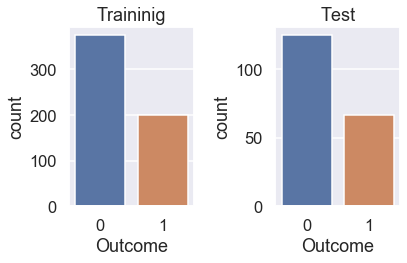

In [41]:
_, ax = plt.subplots(1,2, tight_layout=True)
sns.countplot(ytrain, ax=ax[0]).set_title('Traininig')
sns.countplot(ytest, ax=ax[1]).set_title('Test');

## 4. Creating and evaluate models

### Creating a baseline model

Before attempting more complex models, that take more time to train and evaluate, we will start with a simple [decision tree classifier](https://scikit-learn.org/stable/modules/tree.html).

It will not peform greatly, but it will beat the baseline with a few lines of code.

This will be our baseline model. Any other model we try should beat this model. If it does not, we should not use that model (as a general rule - there may be reasons to chose a less performant model, but these reasons are rare).

In [66]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### Evaluating the baseline model

Predict the test set and checks the accuracy, as a first measure of performance.

In [48]:
pred = dtc.predict(Xtest)

In [56]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ytest, pred))

0.7447916666666666


### Understanding where the model makes mistakes

The model accuracy tells only a general picture. We need to understand where the mistakes are being made. The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) tells us where the errors are.

In [92]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, pred)
print(cm)

[[106  19]
 [ 30  37]]


The layout of the confusion matrix (as used in scikit-learn - other places, [like the Wikipedia article on it](https://en.wikipedia.org/wiki/Confusion_matrix), may invert the axes):

```
     +-----------------------------+---------------------------+
     | True negatives              | False positives           |
     | Predicted "not diabetic",   | Prediced "is diabetic",   |
     | and is fact not diabetic    | but is not diabetic       |
     +-----------------------------+---------------------------+
     | False negatives             | True positive             |
     | Predicted "not diabetic",   | Predicted "diabetic" and  |
     | but is in fact diabetic     | is in fact diabetic"      |
     +-----------------------------+---------------------------+
```

A visual representation is more useful when showing results to stakeholders.

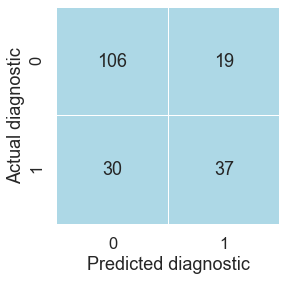

In [93]:
def plot_cm(cm):
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap=['lightblue'],
                     linewidths=0.5)
    ax.set_ylabel('Actual diagnostic')
    ax.set_xlabel('Predicted diagnostic')

plot_cm(cm)

The confusion matrix shows that the classifier makes more mistakes in the "diabetic" class (the "1" class). This is not surprising, given that we have fewer samples of that class in the training dataset.

A way to think about these mistakes that relates to real world outcomes of this model:

- We will recommend treatment for 19 people who do not need any treatment at all ([false positive, type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)). These people will have a miserable life, with a restricted diet.
- We will let 30 people go without the treatment they need ([false negative, type II error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)). These people will suffer physical pain, debilitation and premature death.

This representation of the predictions also shows the perils of relying on accuracy alone to evaluate a model. The accuracy of this model is in the "not too bad" category (not a scientific term), especially considering the amount of effort to create it (literally two lines of code). Digging deeper with the confusion matrix reveals its weak points.

There are more precise metrics to understand what type of mistakes the models is making. We will use [`classification_report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) to show them.

In [53]:
from sklearn.metrics import classification_report

print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       125
           1       0.66      0.55      0.60        67

    accuracy                           0.74       192
   macro avg       0.72      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192



The meaning of these metrics:

>> TODO

